# Задание №3, часть А

## Загрузка данных

In [62]:
# ! curl http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data > ./data/ionosphere.data

## Подготовка данных

In [63]:
from random import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas
import numpy

numpy.random.seed(110)

In [64]:
# Загружаем данные
data = pandas.read_csv('./data/ionosphere.data', header=None) # Load data
data.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [89]:
# Делим на обучающую и тестовую выборки
train, test = train_test_split(data, test_size=0.3)

X_train = train[range(0, 34)]
y_train = train[34].map({"g": 1, "b": 0})
y_train.name = "class"

X_test = test[range(0, 34)]
y_test = test[34].map({"g": 1, "b": 0})
y_test.name = "class"

In [90]:
# Масштабируем и понижаем размерность
from typing import NamedTuple
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler

class ScaledData(NamedTuple):
    umap: object
    tsne: object

X = data[range(0, 34)]

scaler = RobustScaler() # Выбран так как в предыдущей работе показал наилучшую эффективность.
umap_reducer = UMAP()
tsne_reducer = TSNE(init='random', learning_rate='auto')

scaler.fit(X)
X_train = ScaledData(
    umap=pandas.DataFrame(umap_reducer.fit_transform(scaler.transform(X_train)), columns=['p1', 'p2']),
    tsne=pandas.DataFrame(tsne_reducer.fit_transform(scaler.transform(X_train)), columns=['p1', 'p2'])
)

X_test = ScaledData(
    umap=pandas.DataFrame(umap_reducer.fit_transform(scaler.transform(X_test)), columns=['p1', 'p2']),
    tsne=pandas.DataFrame(tsne_reducer.fit_transform(scaler.transform(X_test)), columns=['p1', 'p2'])
)

X_train.umap

,p1,p2
0,16.952671,6.099191
1,13.440019,6.476411
2,9.301306,3.984882
3,16.070387,8.479919
4,10.977226,2.588171
...,...,...
240,16.671417,6.325839
241,16.023390,5.193024
242,15.427380,5.855347
243,11.863013,5.308008


## Построение модели
Строится модель простого классификатора, для того чтобы оценить потом профит от подбора гиперпараметров

In [92]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def scores(y_true, y_pred):
    return { 
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
    }

classifier = KNeighborsClassifier()
model = classifier.fit(X_train.umap.values, y_train)

y_predicted = classifier.predict(X_test.umap.values)
print(scores(y_test, y_predicted))

{'accuracy': 0.3867924528301887, 'precision': 0.5849056603773585, 'f1': 0.4881889763779527, 'recall': 0.4189189189189189}


## Подбор гиперпараметров

In [93]:
from sklearn.model_selection import GridSearchCV

class Result(NamedTuple):
    y_predicted: object
    classifier: object

parameters = { 
    "n_neighbors": list(range(1, 21)),
    "leaf_size": list(range(1, 31)),
    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"] }

scaled_sets = [
    ("UMAP", X_train.umap, X_test.umap), 
    ('T-SNE', X_train.tsne, X_test.tsne)]

results = {}

for label, X_train_, X_test_ in scaled_sets:
    classifier = GridSearchCV(KNeighborsClassifier(), param_grid=parameters)

    model = classifier.fit(X_train_.values, y_train.values)

    classifier = model.best_estimator_
    y_predicted = classifier.predict(X_test_.values)
    results[label] = Result(y_predicted, classifier)
    print(label, model.best_params_)
    print(label, scores(y_test, y_predicted))

UMAP {'leaf_size': 1, 'metric': 'chebyshev', 'n_neighbors': 3}
UMAP {'accuracy': 0.39622641509433965, 'precision': 0.5925925925925926, 'f1': 0.5, 'recall': 0.43243243243243246}
T-SNE {'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 6}
T-SNE {'accuracy': 0.6226415094339622, 'precision': 0.8269230769230769, 'f1': 0.6825396825396826, 'recall': 0.581081081081081}


## Визуализация

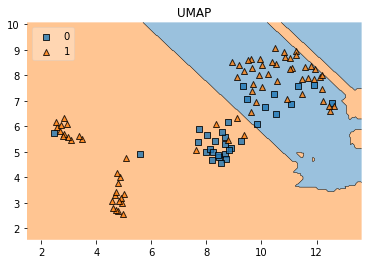

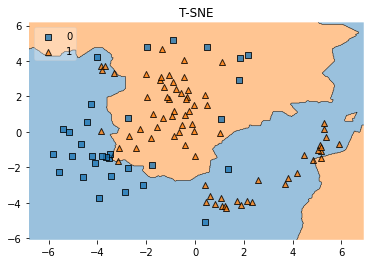

In [94]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

def plot_KNN(X, y_act, y_pred, clf, text):
  plot_decision_regions(X, y_act, clf=clf, legend=2)
  plt.title(text)
  plt.show()

for label, X_train_, X_test_ in scaled_sets:
    plot_KNN(X_test_.to_numpy(), y_test.to_numpy(), results[label].y_predicted, results[label].classifier, label)